In [173]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
import os
import tensorflow as tf
import keras
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.losses import huber_loss
import numpy as np
import matplotlib.pyplot as plt

In [24]:
factor_store = pd.HDFStore('/home/data/training_x_150.h5', mode='r')
variety = 'RB'
factor_df = factor_store.get(variety)
factor_df.head()

,c001,f000,f001,f002,f003,f004,f005,f006,f007,f008,...,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158
start_time,,,,,,,,,,,,,,,,,,,,,
2015-04-29 13:45:42.500,0,0.391508,0.621605,0.020106,0.133344,-0.208305,0.060693,-0.036585,-0.042683,0.859854,...,-1.000000,-1.0,-0.003750,-0.545455,-0.234518,-0.036463,0.095238,0.191476,-0.097238,0.893617
2015-04-29 13:46:23.500,0,0.496306,0.539913,0.123895,0.065477,-0.019297,-0.043244,0.014388,-0.021583,0.937081,...,-0.979798,-1.0,-0.003939,-0.565217,-0.259640,-0.047200,0.084524,0.163595,-0.073619,0.913043
2015-04-29 13:47:33.000,0,0.458761,0.653943,0.103727,0.124588,-0.092521,0.045566,-0.006711,-0.144295,0.897399,...,-1.000000,-1.0,-0.004375,-0.608696,-0.280561,-0.055301,0.075000,0.139095,-0.053190,0.812500
2015-04-29 13:48:47.500,0,0.399437,0.605034,0.092632,0.030653,0.015709,-0.090672,0.003012,-0.224398,0.923290,...,-0.949495,-1.0,-0.004194,-0.590909,-0.293113,-0.058812,0.080952,0.120357,0.002143,0.812500
2015-04-29 13:51:33.500,0,0.526496,0.478210,0.088870,0.159128,-0.061213,-0.025549,-0.011050,-0.198895,0.922161,...,-1.000000,-1.0,-0.005172,-0.681818,-0.322367,-0.070498,0.080952,0.107619,0.027619,0.851064


In [164]:
y_store = pd.HDFStore('/home/data/training_y_reg_150.h5', mode='r')
y_series = y_store.get(variety)
y_series.head()

start_time
2015-04-29 13:45:42.500   -0.042061
2015-04-29 13:46:23.500   -0.210305
2015-04-29 13:47:33.000   -0.168279
2015-04-29 13:48:47.500   -0.252419
2015-04-29 13:51:33.500   -0.210482
Name: Y_logret, dtype: float64

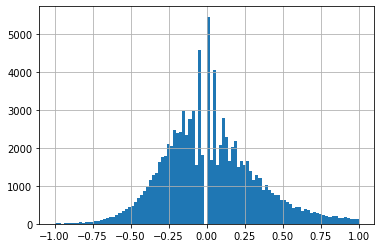

In [197]:
ret_y_series = np.exp(y_series) - 1
ret_y_series.hist(range=(-1,1), bins=100)

In [198]:
ret_y_series.describe()

count    99419.000000
mean         0.116054
std          3.241139
min         -0.999923
25%         -0.183089
50%          0.000000
75%          0.229571
max        355.517368
Name: Y_logret, dtype: float64

In [210]:
ret_y_series.quantile(q=0.6)

0.08375886505374186

In [165]:
y_series.describe()

count    99419.000000
mean         0.001237
std          0.379694
min         -9.468834
25%         -0.202225
50%          0.000000
75%          0.206665
max          5.876383
Name: Y_logret, dtype: float64

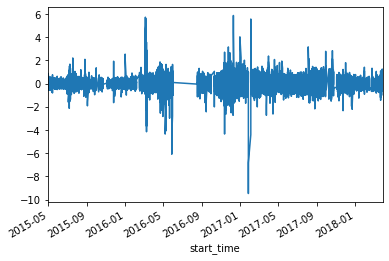

In [185]:
plt.close('all')
y_series.cumsum()
y_series.plot()

In [179]:
np.log(0.1)

-2.3025850929940455

In [156]:
assert (factor_df.index == y_series.index).all()

In [157]:
factor_train, factor_test, y_train, y_test = train_test_split(factor_df, y_series, test_size=0.25, shuffle=False)


In [158]:
def set_gpu_option():
    os.environ["CUDA_VISIBLE_DEVICES"]="1" 
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)
    keras.backend.tensorflow_backend.set_session(sess)
    
def create_model(in_shape):
    NUM_NEURONS = 128
    model = Sequential()
    model.add(Dense(NUM_NEURONS, input_shape=input_shape, activation='relu'))
    model.add(Dense(NUM_NEURONS, activation='relu'))
    model.add(Dense(NUM_NEURONS, activation='relu'))
    model.add(Dense(NUM_NEURONS, activation='relu'))
    model.add(Dense(NUM_NEURONS, activation='relu'))
    model.add(Dense(NUM_NEURONS, activation='relu'))
    model.add(Dense(NUM_NEURONS, activation='relu'))
    model.add(Dense(1, activation='linear'))  
    model.summary()
    
    return model

In [159]:
input_shape = (factor_df.shape[1],)

model = create_model(in_shape=input_shape)
set_gpu_option()
model.compile(optimizer=Adam(lr=1e-3),loss=huber_loss)
model.fit(x=factor_train, y=y_train, epochs=10, verbose=1, validation_split=0.1)
model.evaluate(x=factor_test, y=y_test)
          

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_145 (Dense)            (None, 128)               22656     
_________________________________________________________________
dense_146 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_147 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_148 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_149 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_150 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_151 (Dense)            (None, 128)             

0.07380857783570373

In [161]:
predict_y_test = model.predict(x=factor_test)
predict_y_test_series = pd.Series(data=predict_y_test.flatten(), index=y_test.index, name='predict_y_test')
predict_y_test_series

start_time
2017-06-26 09:28:27.500    1.060412
2017-06-26 09:30:07.000    1.060412
2017-06-26 09:32:50.000    1.060412
2017-06-26 09:35:15.000    1.060412
2017-06-26 09:40:52.000    1.060412
2017-06-26 09:44:25.500    1.060412
2017-06-26 09:48:15.500    1.060412
2017-06-26 09:50:42.000    1.060412
2017-06-26 09:55:42.500    1.060412
2017-06-26 09:58:18.500    1.060412
2017-06-26 10:00:26.500    1.060412
2017-06-26 10:05:13.000    1.060412
2017-06-26 10:07:45.000    1.060412
2017-06-26 10:30:09.000    1.060412
2017-06-26 10:32:03.500    1.060412
2017-06-26 10:34:42.500    1.060412
2017-06-26 10:36:59.500    1.060412
2017-06-26 10:42:23.000    1.060412
2017-06-26 10:50:29.500    1.060412
2017-06-26 10:56:30.000    1.060412
2017-06-26 11:00:12.500    1.060412
2017-06-26 11:01:17.000    1.060412
2017-06-26 11:02:24.000    1.060412
2017-06-26 11:07:02.000    1.060412
2017-06-26 11:08:03.000    1.060412
2017-06-26 11:09:02.000    1.060412
2017-06-26 11:09:31.000    1.060412
2017-06-26 11:10:

In [91]:
y_test

start_time
2017-06-26 09:28:27.500   -0.032067
2017-06-26 09:30:07.000   -0.096231
2017-06-26 09:32:50.000   -0.128535
2017-06-26 09:35:15.000   -0.096355
2017-06-26 09:40:52.000   -0.513810
2017-06-26 09:44:25.500   -0.481465
2017-06-26 09:48:15.500   -0.128370
2017-06-26 09:50:42.000    0.064164
2017-06-26 09:55:42.500    0.353074
2017-06-26 09:58:18.500    0.192616
2017-06-26 10:00:26.500    0.417671
2017-06-26 10:05:13.000    0.289157
2017-06-26 10:07:45.000    0.000000
2017-06-26 10:30:09.000    0.000000
2017-06-26 10:32:03.500    0.096077
2017-06-26 10:34:42.500    0.128205
2017-06-26 10:36:59.500    0.000000
2017-06-26 10:42:23.000   -0.353528
2017-06-26 10:50:29.500   -0.225044
2017-06-26 10:56:30.000   -0.611229
2017-06-26 11:00:12.500   -0.738959
2017-06-26 11:01:17.000   -0.385110
2017-06-26 11:02:24.000   -0.128329
2017-06-26 11:07:02.000    0.225117
2017-06-26 11:08:03.000    0.096510
2017-06-26 11:09:02.000    0.257815
2017-06-26 11:09:31.000    0.128908
2017-06-26 11:10:

In [76]:
factor_train, factor_test, y_train, y_test = train_test_split(factor_df, y_series, test_size=0.25, shuffle=False)

,c001,f000,f001,f002,f003,f004,f005,f006,f007,f008,...,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158
start_time,,,,,,,,,,,,,,,,,,,,,
2017-06-26 09:28:27.500,0,0.659444,0.361323,0.124693,0.035322,0.000439,-0.187917,0.045226,-0.060302,0.955379,...,0.656566,0.575758,-0.001158,-0.207547,-0.464131,-0.240405,0.401316,0.280108,0.643732,0.812500
2017-06-26 09:30:07.000,0,0.670770,0.340530,0.048595,0.048165,-0.017165,-0.027069,-0.003067,0.004601,0.931486,...,0.616162,0.575758,-0.000108,-0.021277,-0.361604,-0.177121,0.463158,0.294303,0.800867,0.828829
2017-06-26 09:32:50.000,0,0.615574,0.386582,0.023649,0.047859,-0.042082,-0.040098,-0.017241,0.079310,0.878137,...,0.191919,0.575758,0.000000,0.000000,-0.262342,-0.118634,0.508480,0.316690,0.892058,0.819820
2017-06-26 09:35:15.000,0,0.495852,0.516137,0.030558,0.054404,-0.023043,-0.047867,0.001484,-0.103858,0.965186,...,0.373737,0.595960,-0.000947,-0.173077,-0.191958,-0.077510,0.548684,0.347634,0.950785,0.801802
2017-06-26 09:40:52.000,0,0.557426,0.453824,0.057840,0.038567,0.064315,-0.092178,0.014052,-0.080796,0.909392,...,0.757576,0.616162,-0.000505,-0.096154,-0.121411,-0.038361,0.592544,0.385207,1.007219,0.870370
2017-06-26 09:44:25.500,0,0.568492,0.457017,0.048735,0.071056,-0.011376,-0.045159,0.002174,-0.044565,0.947866,...,0.919192,0.656566,0.000101,0.020408,-0.044430,0.002047,0.639181,0.429137,1.059271,0.854545
2017-06-26 09:48:15.500,0,0.615329,0.402207,0.032208,0.038619,-0.044898,-0.001190,-0.017065,0.051195,0.956583,...,0.757576,0.696970,0.002143,0.545455,0.071458,0.059889,0.666667,0.472624,1.054753,0.821429
2017-06-26 09:50:42.000,0,0.512648,0.502701,0.044784,0.025876,-0.095700,0.030078,-0.003328,-0.103993,0.963818,...,0.555556,0.696970,0.003784,1.217391,0.190461,0.116396,0.680702,0.512529,1.017048,0.812500
2017-06-26 09:55:42.500,0,0.448473,0.556214,0.019288,0.066020,-0.136553,0.078886,-0.022436,0.008013,0.977124,...,0.070707,0.656566,0.001944,0.482759,0.232157,0.131424,0.686952,0.551670,0.957515,0.796460
